# Module 1 Project 
#### Alice Kwon
#### Part Time
#### Instructor: Eli Thomas

In [ ]:
'''
Organization:
We split each cell with the following labels:
1. Import
2. Webscraping
3. Making Dataframe
4. Cleaning Dataframe
5. Organizing data
6. Visualization
For each label we add a small description if necessary

For this project we need not use databases HOWEVER, they can be used and is often a good idea to use when
handling large amounts of data. Hence at the end after all questions are anwered we show how to create a table 
and insert the information scraped for those who want to use databases. The scraped data will have a (*) pairing 
with the cells at the end 

Note: This is the final version of the code, hence none of the cells will be run
as they have already been run and tested in a draft version
'''

In [230]:
#Import
from bs4 import BeautifulSoup
import requests
import urllib.parse
import json

In [231]:
#WEBSCRAPING: FUNCTIONS IMDB VIA API 
#Getting movies by title 

# Constants
API_KEY = 'k_PtQ8V2FQ/'
API_URL_SEARCH_MOVIE = 'https://imdb-api.com/en/API/SearchMovie/' + API_KEY
API_URL_SEARCH_TITLE = 'https://imdb-api.com/en/API/Title/' + API_KEY

# Logging
movie_number = 0
found_id_count = 0
id_not_found = 0
movie_not_found = 0
total_added = 0


def fetchMovieByTitle(movie_title, movie_year, keys, catch):
    '''
    Parameters: movie_title: <str> string to find movie id  
                movie_year: <str or int> string or int to find movie id 
                keys: <list or tuple> list of keys of dictionary of response object
                catch: <list or tuple> an empty list to catch results
    Returns: response object and appends to catch
    '''
    encoded_movie_title = urllib.parse.quote(str(movie_title), safe='/', encoding=None, errors=None)
    url = API_URL_SEARCH_MOVIE + encoded_movie_title

    response = requests.request("GET", url)

    if response.status_code != 200:
        print(response.status_code, 'cannot find movie:', movie_title)

        # Logging
        global id_not_found
        id_not_found = id_not_found + 1
        return False
    else:
        print(response.status_code, 'movie found', movie_title)
        data = json.loads(response.text)
        getMovieIdFromResults(data.get('results'), movie_title, movie_year, keys, catch)

        # Logging
        global found_id_count
        found_id_count = found_id_count + 1
        return True

def getMovieIdFromResults(api_result, movie_title, movie_year, keys, catch):
    '''
    Parameters: api_result:<dict> response obj
                movie_title: <str> string to find movie id  
                movie_year: <str or int> string or int to find movie id 
                keys: <list or tuple> list of keys of dictionary of response object
                catch: <list or tuple> an empty list to catch results
    Returns: response object and appends to catch
    '''
    for result in api_result:
        if type(result) is dict:
            get_title = result.get('title')
            get_year = result.get('description')
            get_id = result.get('id')

            if str(movie_title) in str(get_title) and str(movie_year) in str(get_year):
                fetchMovieDataFromId(get_id, keys, catch)
                return True
            else:
                print('the movie', str(movie_title), 'was not found')

                # Logging
                global movie_not_found
                movie_not_found = movie_not_found + 1
                return True
        else:
            print('the result is not a dict')
            return True


def fetchMovieDataFromId(movie_id, keys, catch):
    '''
    Parameters: movie_id: <str> imdb movie id
                keys: <list or tuple> list of keys of dictionary of response object
                catch: <list or tuple> an empty list to catch results
    Returns: response object and appedns to catch
    '''
    global total_added
    #all data is present
    if total_added >= 2000:
        return True

    url = API_URL_SEARCH_TITLE + movie_id
    response = requests.request("GET", url)

    if response.status_code != 200:
        print(response.status_code, 'cannot find movie for id:', movie_id)
        return False
    else:
        results = json.loads(response.text)
        log_results = []
        result = [movie_id] + [results.get(key) for key in keys if results.get(key) != '']
        catch.append(tuple(result))
        log_results.append(result)    

        # Logging
        total_added = total_added + 1
        print('appending', log_results, total_added)
        

In [232]:
#WEBSCRAPING: Functions scraping IMDB via beautiful soup

#Letting sites know we are a browser
def iAmBrowser(url):
    headers = requests.utils.default_headers()
    headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',})
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content ,'lxml')
    return soup

#making dictionary to create dataframe with metascore, metacritic, maturity rating, imdb rating, num of imdb votes 
def making_list(movie_id, catch):
    '''
    Parameters: movie_id: <str> imdb movie id
                catch:<list or tuple> empty list to catch result
    Returns: <list> catch
    '''
    metascore = retrieveMetascore(movie_id)[0]
    metacritic = retrieveMetascore(movie_id)[1]
    mrating = retrieveMaturityRating(movie_id)
    imdbScore = retrieveImdbrating(movie_id)[0]
    imdbVotes = retrieveImdbrating(movie_id)[1]
    result = (movie_id, metascore, metacritic, mrating, imdbScore, imdbVotes)
    catch.append(result)
    return catch

#retrieving metascore for each movie 
def retrieveMetascore(movie_id):
    '''
    Parameters: movie_id: <str> string to get url for movie
    Returns: metascore:<str> metascore of movie and number of metacritics
    '''
    url = 'https://www.imdb.com/title/' + movie_id + '/criticreviews?ref_=tt_ov_rt'
    soup = iAmBrowser(url)
    
    metascore = soup.find('span', {'itemprop': 'ratingValue'})
    if metascore:
        metascore = metascore.text.strip()
        #print('appending metascore:' + metascore)
    
    else:
        metascore = 'None'
        #print('Not found')
    
    metacritics = soup.find('span', {'itemprop': 'ratingCount'})
    if metacritics:
        metacritics = metacritics.text.strip()
        #print('appending metacritic:' + metacritics)
    else:
        metacritics = 'None'
        #print('Not found')
    
    return metascore, metacritics

#retrieving maturity rating for each movie
def retrieveMaturityRating(movie_id):
    '''
    Parameters: movie_id:<str> movie id
    Returns: <str> maturity rating
    '''
    url = 'https://www.imdb.com/title/' + movie_id + '/parentalguide?ref_=tt_stry_pg'
    soup = iAmBrowser(url)
    
    MaturityRating = soup.find(id='mpaa-rating')
    
    if MaturityRating:
        MaturityRating = MaturityRating.find_all("td")[1].string.split()[:2]
        #print('appending Mrating')
        
    else:
        MaturityRating = 'None'
        #print('Not found')
        
    return listToString(MaturityRating)

#retrieving Imdb rating and number of votes for each movie 
def retrieveImdbrating(movie_id):
    '''
    Parameters: movie_id:<str> movie id
    Returns: <str> imdb score and number of imdb voters
    '''
    url = "https://www.imdb.com/title/" + movie_id + "/ratings"
    soup = iAmBrowser(url)
    
    numVotes = soup.find('div',{'class': 'allText'})
    if numVotes:
        numVotes = numVotes.text.strip()
        #print('appending numVotes')
        
    else:
        numVotes = 'None'
        #print('Not found')
        
    rating = soup.find('div',{'class': 'allText'})
    if rating:
        rating = rating.text.strip()
        #print('appending rating')
    
    else:
        rating = 'None'
        #print('Not found')
    
    return numVotes.split()[0], listToString(rating.split()[-3:])

def listToString(s):   
    str1 = ""   
    for item in s:  
        str1 += ' ' + item     
    return str1


In [233]:
#retrieving imdb movie id for each movie from top 100 of each year
def top_100(url, catch):
    '''
    Parameters: url: <url> url to request
                catch: <list or tuple> empty list or tuple to catch results
    Returns: appends movie ids to catch
    '''
    soup = iAmBrowser(url)
    Movie = soup.find('div', attrs = {'class': 'lister list detail sub-list'})
    Movie = Movie.find('div', attrs = {'class' : 'lister-list'})
    items = Movie.find_all('div', class_= 'lister-item mode-detail')
    
    for item in items:
        movie_id = item.find('div', attrs={'class': 'lister-item-image ribbonize'})
        movie_id = str(item)
        for strings in str(movie_id).split():
            if 'data-tconst' in strings:
                movie_id = strings.split('=')
                movie_id = movie_id[1].split('>')
                movie_id = movie_id[0].strip('\"')
                catch.append(movie_id)
    #catch = list(dict.fromkeys(catch))
    #return catch

In [234]:
#WEBSCRAPING: functions scraping IMDB via beautiful soup

#function which retrieves votes 
def retrieveVotes(movie_id):
    '''
    Parameters: movie_id:<str> movie id
    Returns: <list> list of number of votes 
    '''
    url = "https://www.imdb.com/title/" + movie_id + "/ratings"
    soup = iAmBrowser(url)
    
    table = soup.find('table')
    
    if not table:
        votes_list.append((movie_id , 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
    
    result =[]
    rows = table.find_all('tr')    
    for tr in rows:
        votes = tr.find('div',{ 'class':'leftAligned'}).text.strip()
        if votes != 'Votes':
            votes = int(votes.replace(',', ''))
            result.append(votes)
            print('appending Votes')
        
    reverse_votes = result[::-1]
    return reverse_votes

#function which makes the tuple of votes we've found 
def makeVotesTuple(movie_id, title, catch):
    '''
    Parameters: movie_id:<str> movie id 
                title:<str> title of movie
                catch:<list> empty list to catch results
    Returns: appends results of retrieveVotes() to list catch
    '''
    catch.append((movie_id, title) + tuple([i for i in retrieveVotes(movie_id)]))

In [235]:
'''
Procedure (A):
1. We will first scrape the movie ids of 100 movies sorted by popularity for each year for the past ten years
2. We then scrape using API: directors, genres, titles, boxoffice, year
3. We then scrape using beautiful soup: metascore, imdb-score, maturity rating
4. We then scrap using beautiful soup: imdb vote chart from 1-10
'''

'\nProcedure (A):\n1. We will first scrape the movie ids of 100 movies sorted by popularity for each year for the past ten years\n2. We then scrape using API: directors, genres, titles, boxoffice, year\n3. We then scrape using beautiful soup: metascore, imdb-score, maturity rating\n4. We then scrap using beautiful soup: imdb vote chart from 1-10\n'

In [236]:
#WEBSCRAPING: we are going to scrape the movie ids (see procedure(A) 1)
#top 100 movies sorted by popularity for each year for past ten years 
url_2019 = 'https://www.imdb.com/list/ls041214362/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2018 = 'https://www.imdb.com/list/ls047677021/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2017 = 'https://www.imdb.com/list/ls023426386/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2016 = 'https://www.imdb.com/list/ls063924870/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2015 = 'https://www.imdb.com/list/ls073386152/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2014 = 'https://www.imdb.com/list/ls058177122/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2013 = 'https://www.imdb.com/list/ls053040009/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2012 = 'https://www.imdb.com/list/ls006206951/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2011 = 'https://www.imdb.com/list/ls000463584/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'
#url_2010 = 'https://www.imdb.com/list/ls009654807/?sort=moviemeter,asc&st_dt=&mode=detail&page=1'

top_100_2019 = []
#top_100_2018 = []
#top_100_2017 = []
#top_100_2016 = []
#top_100_2015 = []
#top_100_2014 = []
#top_100_2013 = []
#top_100_2012 = []
#top_100_2011 = []
#top_100_2010 = []
top_100(url_2019, top_100_2019)  
#top_100(url_2018, top_100_2018)  
#top_100(url_2017, top_100_2017)  
#top_100(url_2016, top_100_2016)  
#top_100(url_2015, top_100_2015)  
#top_100(url_2014, top_100_2014)  
#top_100(url_2013, top_100_2013)  
#top_100(url_2012, top_100_2012)  
#top_100(url_2011, top_100_2011)  
#top_100(url_2010, top_100_2010)  


In [237]:
#(*) see cell 1 at the end 
#WEBSCRAPING: we will use the combined ids obtained to retrieve data (see procedure(A) 2) 
#top_100_10yrs = top_100_2019+top_100_2018+top_100_2017+top_100_2016+top_100_2015+top_100_2014+top_100_2013+top_100_2012+top_100_2011+top_100_2010
top100_10yrs = []
keys = ['title', 'genres', 'directors', 'year', 'boxOffice']
for movie_id in list(set(top_100_2019))[:10]:
    fetchMovieDataFromId(movie_id, keys, top100_10yrs)

appending [['tt2584384', 'Jojo Rabbit', 'Comedy, Drama, War', 'Taika Waititi', '2019', {'budget': '$14,000,000 (estimated)', 'openingWeekendUSA': '$349,555, 20 October 2019', 'grossUSA': '$33,370,906', 'cumulativeWorldwideGross': '$90,335,025'}]] 1
appending [['tt8946378', 'Knives Out', 'Comedy, Crime, Drama, Mystery, Thriller', 'Rian Johnson', '2019', {'budget': '$40,000,000 (estimated)', 'openingWeekendUSA': '$26,769,548, 1 December 2019', 'grossUSA': '$165,363,234', 'cumulativeWorldwideGross': '$309,232,797'}]] 2
appending [['tt10199640', 'Beanpole', 'Drama, War', 'Kantemir Balagov', '2019', {'budget': '', 'openingWeekendUSA': '$10,008, 2 February 2020', 'grossUSA': '$196,258', 'cumulativeWorldwideGross': '$1,950,414'}]] 3
appending [['tt1302006', 'The Irishman', 'Biography, Crime, Drama', 'Martin Scorsese', '2019', {'budget': '$159,000,000 (estimated)', 'openingWeekendUSA': '', 'grossUSA': '', 'cumulativeWorldwideGross': '$968,853'}]] 4
appending [['tt8193790', 'Deerskin', 'Comedy,

In [238]:
#top100_10yrs

In [239]:
#(*) see cell 2 at the end
#WEBSCRAPING: we will use the combined ids obtained to retrieve data (see procedure(A) 3)
top100_10yrs2 = []
for movie_id in list(set(top_100_2019))[:10]:
    making_list(movie_id, top100_10yrs2)

In [240]:
#top100_10yrs2

In [241]:
import pandas as pd

In [242]:
#(*) see cell 1 at the end 
#MAKING DATAFRAME: Before proceeding to procedure 4 we will make a dataframe called all.csv (see prcedure(B) 1)

#separate boxoffice which is a dictionary with the rest of data
CONFIG = {'MOVIE_INFO_COLUMN_NAMES' : ['ids', 'titles', 'genres', 'directors', 'year'],
          'MOVIE_RATING_COLUMN_NAMES' : ['ids', 'metascore', 'metacritics', 'mrating', 'imdbvotes','imdbScore'],
          'VOTES_COLUMN_NAMES' : ['ids', 'title','one', 'two', 'three','four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
         }

boxOffice = [x[5] for x in top100_10yrs]
listToDf = [(x[0],x[1],x[2],x[3], x[4]) for x in top100_10yrs]

#make each into a dataframe
listToDf_df = pd.DataFrame(listToDf, columns = CONFIG.get('MOVIE_INFO_COLUMN_NAMES'))
boxoffice_df = pd.DataFrame(boxOffice)

#concatenate the two dataframes
movie_info_df = pd.concat([listToDf_df, boxoffice_df], axis =1, join = 'inner')

#make the dataframe of the retrieved ratings 
movie_ratings_df = pd.DataFrame(top100_10yrs2, columns = CONFIG.get('MOVIE_RATING_COLUMN_NAMES'))

#merge the two dataframes on ids
all_df = movie_info_df.merge(movie_ratings_df, on = 'ids')

#save this dataframe as all.csv
#all_df.to_csv(r'<insert path here>/all.csv', mode='w', header=True, index=False)

In [243]:
#all_df

In [244]:
#WEBSCRAPING: we will use the combined ids obtained to retrieve data (see procedure(A) 4)
votes_list = []
list_movie_id = all_df['ids']
list_titles = all_df['titles']
for movie_id, title in zip(list_movie_id, list_titles):
    makeVotesTuple(movie_id, title, votes_list)

appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appending Votes
appendin

In [245]:
#votes_list

In [84]:
'''
Procedure(B):
1. We make a dataframe called all_df and save as all.csv which includes data from procedure(A)1,2,3
2. We make a dataframe called votes_df and save as votes.csv which includes data from procedure(A)4
'''

'\nProcedure(B):\n1. We make a dataframe called all_df and save as all.csv which includes data from procedure(A)1,2,3\n2. We make a dataframe called votes_df and save as votes.csv which includes data from procedure(A)4\n'

In [347]:
#MAKING DATAFRAME: making dataframe votes_df and saving as votes.csv (see procedure(B)2)
votes_df = pd.DataFrame(votes_list, columns = CONFIG.get('VOTES_COLUMN_NAMES'))

#save dataframe
#votes_df.to_csv(r'<insert path here>/votes.csv', mode='w', header=True, index=False)

In [348]:
votes_df

,ids,title,one,two,three,four,five,six,seven,eight,nine,ten
0,tt2584384,Jojo Rabbit,1931,770,1057,1779,4190,12220,35429,64732,43793,30623
1,tt8946378,Knives Out,2020,736,953,1665,4337,15146,54374,102673,61242,34308
2,tt10199640,Beanpole,113,52,95,147,281,547,1153,1219,532,326
3,tt1302006,The Irishman,3018,1515,2263,3668,8230,21110,52984,83947,59405,42146
4,tt8193790,Deerskin,79,42,89,109,272,685,1275,746,230,136
5,tt6857112,Us,7847,3541,5037,7749,15063,31048,50171,43035,18365,12825
6,tt0448115,Shazam!,3428,1620,2688,5210,13616,35565,69039,54600,20368,20182
7,tt8991268,Honeyland,108,53,42,79,202,585,1521,2712,1739,2443
8,tt4729430,Klaus,287,92,129,270,808,2794,10285,19969,16457,14662
9,tt10915286,Tell Me Who I Am,61,27,37,93,241,714,2019,2745,1295,1062


## Question 1:
#### What is the 'best' genres and maturity rating pair?

In [ ]:
'''
Procedure(C):
We want to clean data according to how we want to answer our first question
1.  a)We organize to see if there are any genres which trend by counting genre for each year. 
    b)Visualize using a bar graph for each year see if there are any trends in genre.
    c)Save image as All_graphs.
    d) this will determine which combination will be a good combination for genres

2.  a)We calculate average profit for each genre and maturity rating pair.
    b)Visualize using bar graph for profit vs genre,maturity rating pair.
    c)Save image as Genre_profit.

3.  a)We calculate average metascore and imdb score for each genre and maturity rating pair.
    b)Visualize using bargraph for score vs genre,maturity rating pair.
    c)Save image as Genre_score.

4.  a)We calculate average skewness for each genre and maturty rating pair.
    b)Visualize using bargraph for skewness vs genre,maturity rating pair.
    c)Save image as Genre_skew

We take the average since there are no major outliers from observation. 
'''

In [248]:
#ORGANIZING DATA: function which counts genre per year (see procedure(C)1)
genre_dict = {'Action':0, 'Adult':0, 'Adventure':0, 'Animation':0,'Biography':0,
              'Comedy':0, 'Crime':0, 'Documentary':0, 'Drama':0, 'Family':0, 'Fantasy':0,
              'Film_Noir':0, 'Game_Show':0, 'History':0, 'Horror':0, 'Musical':0, 'Music':0, 
              'Mystery':0,'News':0, 'Reality_TV':0, 'Romance':0, 'Sci_Fi':0, 'Short':0, 'Sport':0, 
              'Talk_Show':0,'Thriller':0, 'War':0, 'Western':0}

def counting_genre(value):
    for key in genre_dict.keys():
        if key in value:
            genre_dict[key] = genre_dict[key]+ 1
            return True

In [249]:
#ORGANIZING DATA: we separate into each year (see procedure(C)1)
all2019_df = all_df[all_df['year']== '2019']
#all2018_df = all_df[all_df['year']== '2018']
#all2017_df = all_df[all_df['year']== '2017']
#all2016_df = all_df[all_df['year']== '2016']
#all2015_df = all_df[all_df['year']== '2015']
#all2014_df = all_df[all_df['year']== '2014']
#all2013_df = all_df[all_df['year']== '2013']
#all2012_df = all_df[all_df['year']== '2012']
#all2011_df = all_df[all_df['year']== '2011']
#all2010_df = all_df[all_df['year']== '2010']

In [250]:
#all2019_df

In [251]:
#ORGANIZING DATA: counting genre for each year (see procedure(C)1)
#NOTE: we will have to run this for each year separately and produce graphs separately 
all2019_df['genres'].apply(lambda x: counting_genre(x))

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: genres, dtype: bool

In [252]:
#IMPORT: for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
from PIL import Image

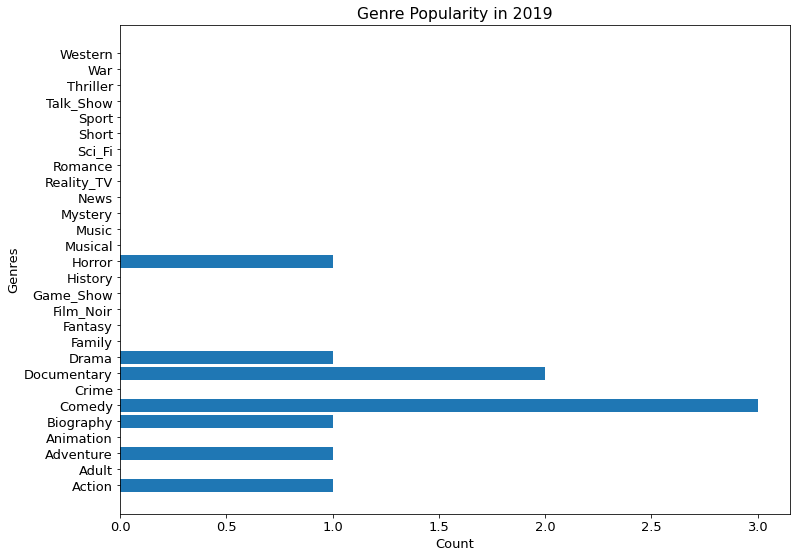

In [254]:
#VISUALIZATION: bar graph shows which is most reoccuring genre (see procedure(C)1)
#NOTE: we will have to run this for each year separately Look at visualizations folder
objects = genre_dict.keys()
y_pos = np.arange(len(objects))
performance = genre_dict.values()
plt.rcParams.update({'font.size': 13})
plt.subplots(figsize=(12,9))
plt.barh(y_pos, performance, align = 'center', alpha = 1.0)
plt.yticks(y_pos, objects)
plt.ylabel('Genres')
plt.xlabel('Count')
plt.title('Genre Popularity in 2019')
#plt.savefig('Genre_2019.png', bbox_inches = 'tight')
plt.show()

In [ ]:
#the next step please skip: there are ways to graph side by side via matplotlib rather than to concatenate images

In [ ]:
#DO NOT RUN
#VISUALIZATION: concatenating all images (see procedure(C)1)
#the functions below were borrowed from https://note.nkmk.me/en/python-pillow-concat-images/
im1 = Image.open('MoreData/2010_12.jpg')
im2 = Image.open('MoreData/2013_15.jpg')
im3 = Image.open('MoreData/2016_18.jpg')
im4 = Image.open('MoreData/Genre_2019.png')
im_list = [im1, im2, im3, im4]


#function to concatenate multiple images horizontally
def get_concat_h_multi_resize(im_list, resample=Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

#function to concatenate multiple images vertically 
def get_concat_v_multi_resize(im_list, resample=Image.BICUBIC):
    min_width = min(im.width for im in im_list)
    im_list_resize = [im.resize((min_width, int(im.height * min_width / im.width)),resample=resample)
                      for im in im_list]
    total_height = sum(im.height for im in im_list_resize)
    dst = Image.new('RGB', (min_width, total_height))
    pos_y = 0
    for im in im_list_resize:
        dst.paste(im, (0, pos_y))
        pos_y += im.height
    return dst

#saving image
get_concat_v_multi_resize(im_list).save('MoreData/All_graphs.jpg')

In [255]:
#MAKING DATAFRAME: making data frame to separate genres (see procedure(C)2)
df_list=[]
for index, rows in all_df.iterrows(): 
    my_list =[rows[i] for i in all_df.columns]  
    if len(my_list[2].split(',')) > 1:
        for item in my_list[2].split(','): 
            df_list.append([*my_list[:2],item,*my_list[3:]])   

In [322]:
#MAKING DATAFRAME: making dataframe separted genres (see procedure(C)2)
singleGenre_df = pd.DataFrame(df_list, columns = all_df.columns)
#singleGenre_df

In [323]:
# we drop information we dont need
singleGenre_df = singleGenre_df.drop(['openingWeekendUSA'], axis=1)

In [324]:
#CLEANING DATAFRAME: each budget and gross should be a float (see procedure(C)2)
singleGenre_df['budget'] = singleGenre_df['budget'].astype(str)
singleGenre_df['budget'] = singleGenre_df['budget'].apply(lambda x: x.replace('$', ''))
singleGenre_df['budget'] = singleGenre_df['budget'].apply(lambda x: x.replace(',', ''))
singleGenre_df['budget'] = singleGenre_df['budget'].apply(lambda x: x.replace('(estimated)', ''))

singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].astype(str)
singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].apply(lambda x: x.replace('$', ''))
singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].apply(lambda x: x.replace(',', ''))

singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].astype(str)
singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].apply(lambda x: x.replace('$', ''))
singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].apply(lambda x: x.replace(',', ''))


In [325]:
singleGenre_df

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,14000000,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,14000000,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,40000000,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,40000000,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,40000000,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,40000000,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
8,tt10199640,Beanpole,Drama,Kantemir Balagov,2019,,196258,1950414,84,26,N o n e,"4,465",7.1 / 10
9,tt10199640,Beanpole,War,Kantemir Balagov,2019,,196258,1950414,84,26,N o n e,"4,465",7.1 / 10


In [326]:
#MAKING DATAFRAME: function for usd conversion (see procedure(C)2)
def convertUSD(value):
    if 'EUR' in value:
        return float(value.replace('EUR',''))*(1.09)
    elif 'NOK' in value:
        return float(value.replace('NOK',''))*(0.096)
    elif 'JPY' in value:
        return float(value.replace('JPY',''))*(0.0093)
    elif 'DKK' in value:
        return float(value.replace('DKK',''))*(0.15)
    elif 'GBP' in value:
        return float(value.replace('GBP',''))*(1.25)
    elif 'INR' in value:
        return float(value.replace('INR',''))*(0.013)
    elif 'KRW' in value:
        return float(value.replace('KRW',''))*(0.00082)
    elif 'CAD' in value:
        return float(value.replace('CAD',''))*(0.71)
    elif 'AUD' in value:
        return float(value.replace('AUD',''))*(0.64)
    else:
        return value

In [327]:
#DO NOT RUN
#CLEANING DATAFRAME: applying usd conversion (see procedure(C)2)
singleGenre_df['budget'] = singleGenre_df['budget'] = singleGenre_df['budget'].apply(lambda x: convertUSD(x))

In [328]:
singleGenre_df['budget'] = singleGenre_df['budget'].apply(lambda x: 0 if x == '' else x )
singleGenre_df['budget'] = singleGenre_df['budget'].astype(float)

In [329]:
singleGenre_df

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000.0,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,14000000.0,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,14000000.0,33370906,90335025,58,57,Rated PG-13,"196,524",7.9 / 10
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000.0,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,40000000.0,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,40000000.0,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,40000000.0,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,40000000.0,165363234,309232797,82,52,Rated PG-13,"277,454",7.9 / 10
8,tt10199640,Beanpole,Drama,Kantemir Balagov,2019,0.0,196258,1950414,84,26,N o n e,"4,465",7.1 / 10
9,tt10199640,Beanpole,War,Kantemir Balagov,2019,0.0,196258,1950414,84,26,N o n e,"4,465",7.1 / 10


In [330]:

#CLEANING DATAFRAME: changing all to float (see procedure(C)2)
singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].fillna('')
singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].apply(lambda x: 0 if x == '' else x )
singleGenre_df['grossUSA'] = singleGenre_df['grossUSA'].astype(float)

singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].fillna('')
singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].apply(lambda x: 0 if x == '' else x )
singleGenre_df['cumulativeWorldwideGross'] = singleGenre_df['cumulativeWorldwideGross'].astype(float)

#making profit column



In [331]:
singleGenre_df = singleGenre_df[singleGenre_df['grossUSA']!=0]
singleGenre_df = singleGenre_df[singleGenre_df['cumulativeWorldwideGross']!=0]

In [332]:
singleGenre_df['profit'] = (0.4*(singleGenre_df['cumulativeWorldwideGross'] - singleGenre_df['grossUSA']) +
                            0.6 *singleGenre_df['grossUSA']) - singleGenre_df['budget']

In [333]:
singleGenre_df

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore,profit
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58,57,Rated PG-13,"196,524",7.9 / 10,28808191.2
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58,57,Rated PG-13,"196,524",7.9 / 10,28808191.2
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58,57,Rated PG-13,"196,524",7.9 / 10,28808191.2
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82,52,Rated PG-13,"277,454",7.9 / 10,116765765.6
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82,52,Rated PG-13,"277,454",7.9 / 10,116765765.6
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82,52,Rated PG-13,"277,454",7.9 / 10,116765765.6
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82,52,Rated PG-13,"277,454",7.9 / 10,116765765.6
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82,52,Rated PG-13,"277,454",7.9 / 10,116765765.6
8,tt10199640,Beanpole,Drama,Kantemir Balagov,2019,0.0,196258.0,1950414.0,84,26,N o n e,"4,465",7.1 / 10,819417.2
9,tt10199640,Beanpole,War,Kantemir Balagov,2019,0.0,196258.0,1950414.0,84,26,N o n e,"4,465",7.1 / 10,819417.2


In [334]:
#DO NOT RUN
#CLEANING DATAFRAME: We only want movies with a maturty rating (see procedure(C)2) 
singleGenre_df['mrating'] = singleGenre_df['mrating'].fillna(' N o n e')
singleGenre_df = singleGenre_df[singleGenre_df['mrating'] != ' N o n e']

In [335]:
#MAKING DATAFRAME: groupby genre and maturity rating mean (see procedure(C)2)
singleGenre_df.groupby(['genres', 'mrating']).mean()

budget     grossUSA  cumulativeWorldwideGross  \
genres     mrating                                                            
 Adventure  Rated PG-13  100000000.0  140371656.0               365971656.0   
 Comedy     Rated PG-13  100000000.0  140371656.0               365971656.0   
 Crime      Rated PG-13   40000000.0  165363234.0               309232797.0   
 Drama      Rated PG-13   27000000.0   99367070.0               199783911.0   
 Fantasy    Rated PG-13  100000000.0  140371656.0               365971656.0   
 Mystery    Rated PG-13   40000000.0  165363234.0               309232797.0   
            Rated R       20000000.0  175084580.0               255184580.0   
 Thriller   Rated PG-13   40000000.0  165363234.0               309232797.0   
            Rated R       20000000.0  175084580.0               255184580.0   
 War        Rated PG-13   14000000.0   33370906.0                90335025.0   
Action      Rated PG-13  100000000.0  140371656.0               365971656.0   
Comedy      Rated PG-13   27000000.0   99367070.0               199783911.0   
Horror      Rated R       20000000.0  175084580.0               255184580.0   

                              profit  
genres     mrating                    
 Adventure  Rated PG-13   74462993.6  
 Comedy     Rated PG-13   74462993.6  
 Crime      Rated PG-13  116765765.6  
 Drama      Rated PG-13   72786978.4  
 Fantasy    Rated PG-13   74462993.6  
 Mystery    Rated PG-13  116765765.6  
            Rated R      117090748.0  
 Thriller   Rated PG-13  116765765.6  
            Rated R      117090748.0  
 War        Rated PG-13   28808191.2  
Action      Rated PG-13   74462993.6  
Comedy      Rated PG-13   72786978.4  
Horror      Rated R      117090748.0

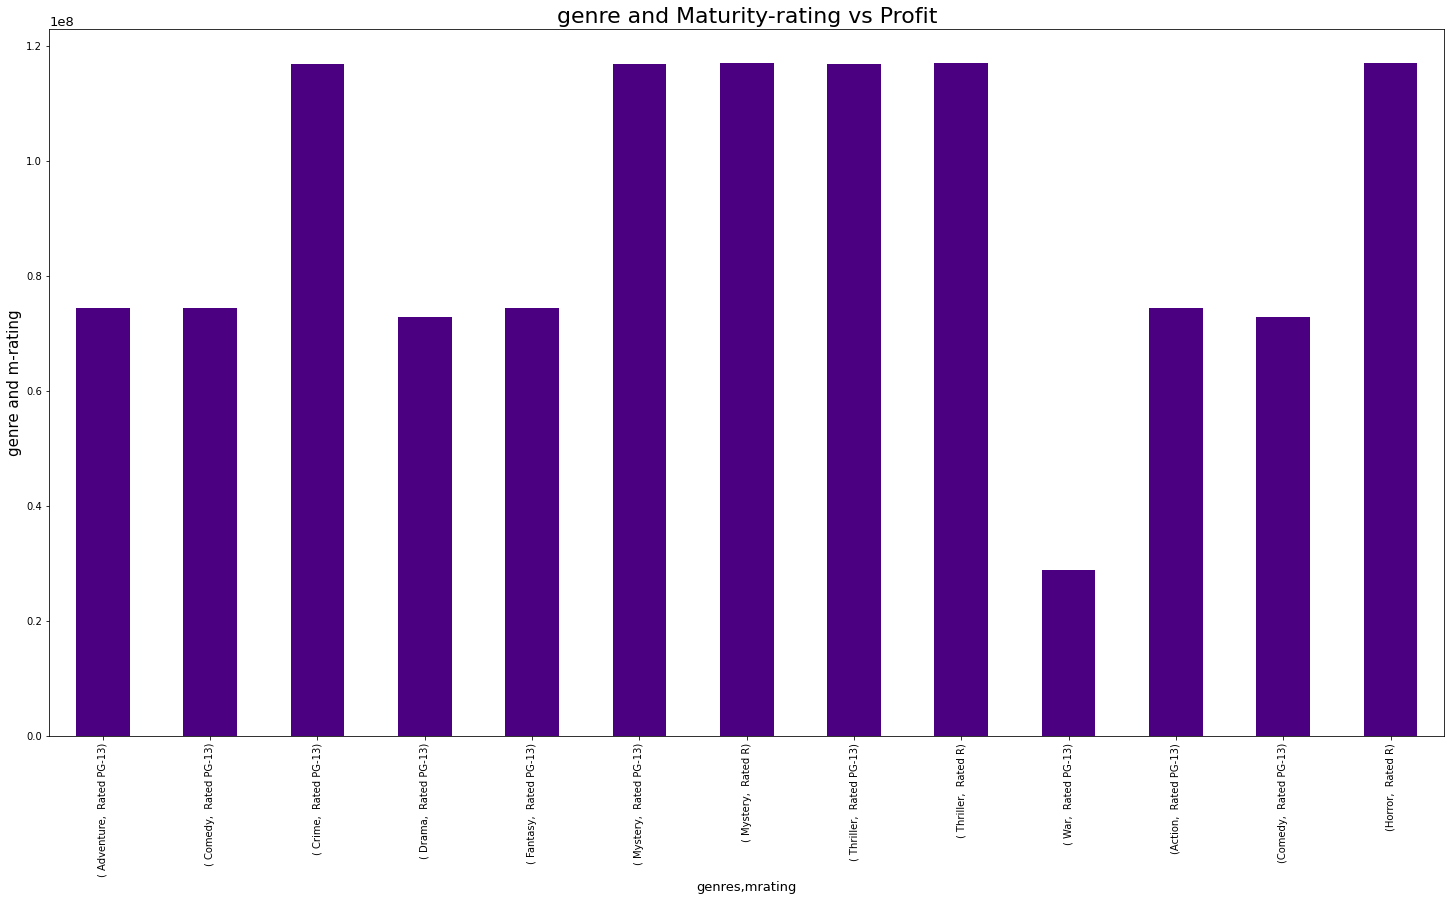

In [336]:
#VISUALIZATION: Genre and Maturity-rating vs Profit (see procedure(C)2)
df = singleGenre_df.groupby(['genres', 'mrating'])['profit'].mean()
ax = df.plot(kind='bar', figsize=(25,13), color="indigo", fontsize=10);
ax.set_alpha(0.8)
ax.set_title("genre and Maturity-rating vs Profit", fontsize=22)
ax.set_ylabel("genre and m-rating", fontsize=15);

#saving image
#plt.savefig('Genre_Profit.png', bbox_inches = 'tight')
plt.show()

In [337]:
#CLEANING DATAFRAME: We want imdbscore and metascore as floats, (see procedure(C)3)
singleGenre_df['imdbScore'] = singleGenre_df['imdbScore'].apply(lambda x: x[:4])
singleGenre_df['imdbScore'] = singleGenre_df['imdbScore'].astype(float)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [338]:
#we want imdbScore to be similar to metascore so we multiply by 10 so both scores are out of 100
singleGenre_df['imdbScore'] = singleGenre_df['imdbScore'].apply(lambda x: x)
singleGenre_df['metascore'] = singleGenre_df['metascore'].fillna(0)

#We only look at those values which are not 0
singleGenre_df['metascore'].astype(float)
singleGenre_df = singleGenre_df[singleGenre_df['metascore'] !=0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [339]:
singleGenre_df['metascore'] = singleGenre_df['metascore'].apply(lambda x: float(x))

In [340]:
singleGenre_df

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore,profit
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
15,tt6857112,Us,Horror,Jordan Peele,2019,20000000.0,175084580.0,255184580.0,81.0,56,Rated R,"194,681",6.9,117090748.0
16,tt6857112,Us,Mystery,Jordan Peele,2019,20000000.0,175084580.0,255184580.0,81.0,56,Rated R,"194,681",6.9,117090748.0


In [341]:
#MAKING DATAFRAME: groupby genre and maturity rating via mean. (see procedure(C)3)
singleGenre_df.groupby(['genres', 'mrating']).mean()

budget     grossUSA  cumulativeWorldwideGross  \
genres     mrating                                                            
 Adventure  Rated PG-13  100000000.0  140371656.0               365971656.0   
 Comedy     Rated PG-13  100000000.0  140371656.0               365971656.0   
 Crime      Rated PG-13   40000000.0  165363234.0               309232797.0   
 Drama      Rated PG-13   27000000.0   99367070.0               199783911.0   
 Fantasy    Rated PG-13  100000000.0  140371656.0               365971656.0   
 Mystery    Rated PG-13   40000000.0  165363234.0               309232797.0   
            Rated R       20000000.0  175084580.0               255184580.0   
 Thriller   Rated PG-13   40000000.0  165363234.0               309232797.0   
            Rated R       20000000.0  175084580.0               255184580.0   
 War        Rated PG-13   14000000.0   33370906.0                90335025.0   
Action      Rated PG-13  100000000.0  140371656.0               365971656.0   
Comedy      Rated PG-13   27000000.0   99367070.0               199783911.0   
Horror      Rated R       20000000.0  175084580.0               255184580.0   

                         metascore  imdbScore       profit  
genres     mrating                                          
 Adventure  Rated PG-13       71.0        7.1   74462993.6  
 Comedy     Rated PG-13       71.0        7.1   74462993.6  
 Crime      Rated PG-13       82.0        7.9  116765765.6  
 Drama      Rated PG-13       70.0        7.9   72786978.4  
 Fantasy    Rated PG-13       71.0        7.1   74462993.6  
 Mystery    Rated PG-13       82.0        7.9  116765765.6  
            Rated R           81.0        6.9  117090748.0  
 Thriller   Rated PG-13       82.0        7.9  116765765.6  
            Rated R           81.0        6.9  117090748.0  
 War        Rated PG-13       58.0        7.9   28808191.2  
Action      Rated PG-13       71.0        7.1   74462993.6  
Comedy      Rated PG-13       70.0        7.9   72786978.4  
Horror      Rated R           81.0        6.9  117090748.0

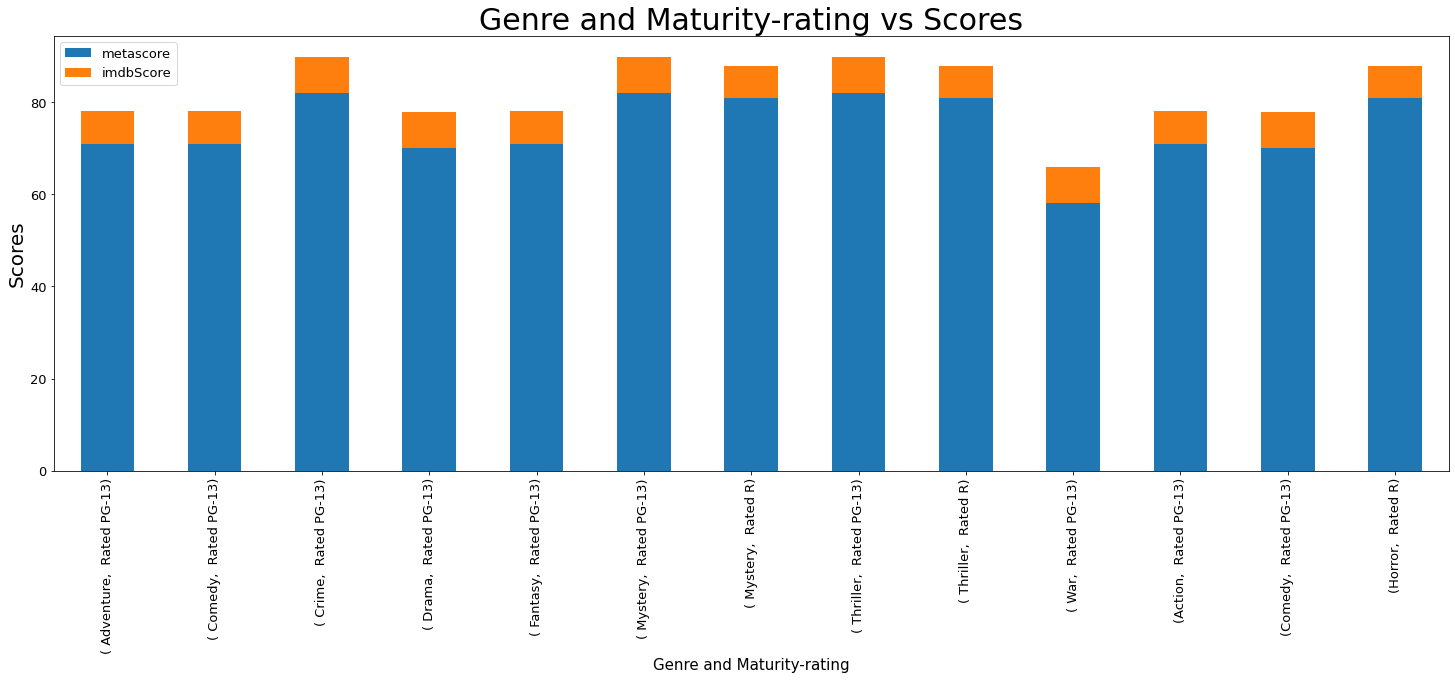

In [342]:
#VISUALIZATION: Genre Maturity rating vs Score (see procedure(C)3)
x= singleGenre_df[['genres','mrating','metascore','imdbScore' ]]
y= x.set_index(['genres', 'mrating'])
z=y.groupby(['genres', 'mrating']).mean()
ax = z.plot(kind= 'bar', figsize=(25,8), stacked=True)
ax.set_title("Genre and Maturity-rating vs Scores", fontsize=30)
ax.set_ylabel("Scores", fontsize=20)

#save image
ax.set_xlabel("Genre and Maturity-rating", fontsize=15)
plt.savefig('Genre_score.png', bbox_inches = 'tight')

In [343]:
#ORGANIZING DATA: functions to calculate skewness for each movie (see procedure(C)4)

#calculating Bowleyskewness or Yules coeff
def bowleySkew(data, freq):
    '''
    Parameters: data:<list> list of data
                freq:<list> frequency of data
    Returns: <float> Bowley's skewness
    '''
    Q1 = calculateValue(25,data,freq)
    Q2 = calculateValue(50,data,freq)
    Q3 = calculateValue(75,data,freq)
    Yule_coeff = (Q3 + Q1 - 2*Q2)/(Q3-Q1)
    return round(Yule_coeff,4)

#calculating value num
def calculateValue(percentile, data, freq):
    '''
    Parameters: percentile: <int> percentile
                data:<list> data
                freq:<list> frequency of data
    Returns: <float> value number 
    '''
    cum_freq = cumulativeFrequency(freq)
    total = cum_freq[-1]
    value_num = (percentile/100)*(total+1)
    if type(value_num) == float:
        value_num = round(value_num)
        if value_num <= cum_freq[0]:
            return data[0]
        else:
            for x in range(0,len(cum_freq)):
                if value_num >= cum_freq[x-1] and value_num <= cum_freq[x]:
                    return data[x]

#calculating cumulative freq
def cumulativeFrequency(freq):
    '''
    Parameters: freq:<list> frequency of data
    Returns: <list> cumulative frequency
    '''
    cum_freq = []
    cum_freq.append(freq[0])
    for x in range(1, len(freq)):
        cum_freq.append(cum_freq[x-1] + freq[x])
    return cum_freq
        
      

In [349]:
#MAKING DATAFRAME: adding skewness to votes_df (see procedure(C)4)
skew_list =[]
votes = [1,2,3,4,5,6,7,8,9,10]
for index, rows in votes_df.iterrows(): 
    my_list =[rows.one, rows.two, rows.three, rows.four, rows.five, rows.six, rows.seven, rows.eight, rows.nine, rows.ten] 
    skew_list.append(bowleySkew(votes, my_list))
    
votes_df['skewness']= skew_list

In [350]:
votes_df = all_df.merge(votes_df, on = 'ids')

In [351]:
votes_df

,ids,titles,genres,directors,year,budget,openingWeekendUSA,grossUSA,cumulativeWorldwideGross,metascore,...,two,three,four,five,six,seven,eight,nine,ten,skewness
0,tt2584384,Jojo Rabbit,"Comedy, Drama, War",Taika Waititi,2019,"$14,000,000 (estimated)","$349,555, 20 October 2019","$33,370,906","$90,335,025",58,...,770,1057,1779,4190,12220,35429,64732,43793,30623,0.0000
1,tt8946378,Knives Out,"Comedy, Crime, Drama, Mystery, Thriller",Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
2,tt10199640,Beanpole,"Drama, War",Kantemir Balagov,2019,,"$10,008, 2 February 2020","$196,258","$1,950,414",84,...,52,95,147,281,547,1153,1219,532,326,0.0000
3,tt1302006,The Irishman,"Biography, Crime, Drama",Martin Scorsese,2019,"$159,000,000 (estimated)",,,"$968,853",94,...,1515,2263,3668,8230,21110,52984,83947,59405,42146,0.0000
4,tt8193790,Deerskin,"Comedy, Horror",Quentin Dupieux,2019,"EUR4,000,000 (estimated)",,,"$1,656,279",73,...,42,89,109,272,685,1275,746,230,136,0.0000
5,tt6857112,Us,"Horror, Mystery, Thriller",Jordan Peele,2019,"$20,000,000 (estimated)","$71,117,625, 24 March 2019","$175,084,580","$255,184,580",81,...,3541,5037,7749,15063,31048,50171,43035,18365,12825,0.0000
6,tt0448115,Shazam!,"Action, Adventure, Comedy, Fantasy",David F. Sandberg,2019,"$100,000,000 (estimated)","$53,505,326, 7 April 2019","$140,371,656","$365,971,656",71,...,1620,2688,5210,13616,35565,69039,54600,20368,20182,0.0000
7,tt8991268,Honeyland,"Documentary, Drama","Tamara Kotevska, Ljubomir Stefanov",2019,,"$31,381, 28 July 2019","$815,082","$1,140,879",86,...,53,42,79,202,585,1521,2712,1739,2443,0.3333
8,tt4729430,Klaus,"Animation, Adventure, Comedy, Family","Sergio Pablos, Carlos Martínez López",2019,"$40,000,000 (estimated)",,,,65,...,92,129,270,808,2794,10285,19969,16457,14662,1.0000
9,tt10915286,Tell Me Who I Am,"Documentary, Drama, Mystery",Ed Perkins,2019,,,,,69,...,27,37,93,241,714,2019,2745,1295,1062,0.0000


In [352]:
#MAKING DATAFRAME: function separating into genres again (see procedure(C)4)

df_list2=[]
for index, rows in votes_df.iterrows(): 
    my_list =[rows[i] for i in votes_df.columns]  
    if len(my_list[2].split(',')) > 1:
        for item in my_list[2].split(','): 
            df_list2.append([*my_list[:2],item,*my_list[3:]]) 

skewd_df = pd.DataFrame(df_list2, columns = votes_df.columns)

In [353]:
skewd_df

,ids,titles,genres,directors,year,budget,openingWeekendUSA,grossUSA,cumulativeWorldwideGross,metascore,...,two,three,four,five,six,seven,eight,nine,ten,skewness
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,"$14,000,000 (estimated)","$349,555, 20 October 2019","$33,370,906","$90,335,025",58,...,770,1057,1779,4190,12220,35429,64732,43793,30623,0.0000
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,"$14,000,000 (estimated)","$349,555, 20 October 2019","$33,370,906","$90,335,025",58,...,770,1057,1779,4190,12220,35429,64732,43793,30623,0.0000
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,"$14,000,000 (estimated)","$349,555, 20 October 2019","$33,370,906","$90,335,025",58,...,770,1057,1779,4190,12220,35429,64732,43793,30623,0.0000
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,"$40,000,000 (estimated)","$26,769,548, 1 December 2019","$165,363,234","$309,232,797",82,...,736,953,1665,4337,15146,54374,102673,61242,34308,0.0000
8,tt10199640,Beanpole,Drama,Kantemir Balagov,2019,,"$10,008, 2 February 2020","$196,258","$1,950,414",84,...,52,95,147,281,547,1153,1219,532,326,0.0000
9,tt10199640,Beanpole,War,Kantemir Balagov,2019,,"$10,008, 2 February 2020","$196,258","$1,950,414",84,...,52,95,147,281,547,1153,1219,532,326,0.0000


In [354]:
#CLEANING DATAFRAME: cleaning mrating same as singleGenres (see procedure(C)4)
skewd_df['mrating'] = skewd_df['mrating'].fillna(' N o n e')
skewd_df.mrating.unique()
skewd_df = skewd_df[skewd_df['mrating'] != ' N o n e']

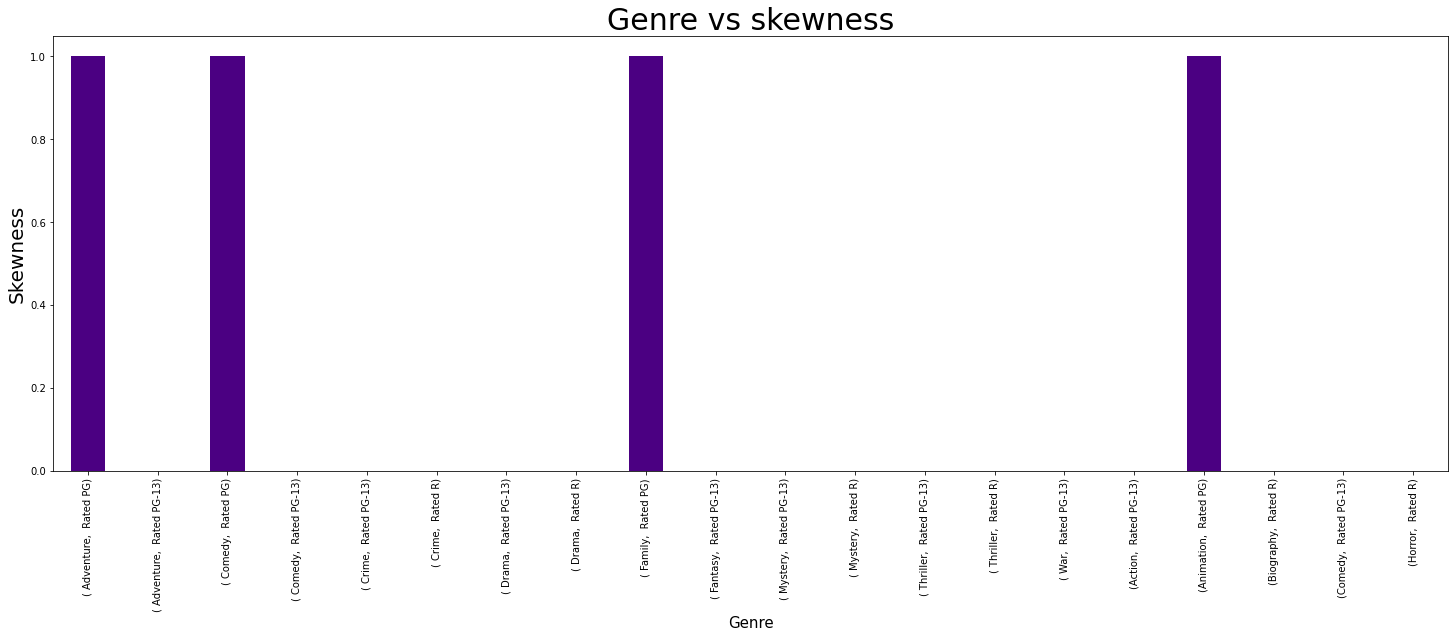

In [355]:
#VISUALIZATION: Genre Maturity rating vs skew (see procedure(C)4)
df = skewd_df.groupby(['genres','mrating'])['skewness'].mean()
ax = df.plot(kind='bar', figsize=(25,8), color="indigo", fontsize=10);
ax.set_alpha(0.8)
ax.set_title("Genre vs skewness", fontsize=30)
ax.set_ylabel("Skewness", fontsize=20)
ax.set_xlabel("Genre", fontsize=15)
plt.savefig('Genre_skew.png', bbox_inches = 'tight')
plt.show()

## ANSWER 1: ((Sci-fi, Action), PG-13), ((Crime, Action), PG), ((Mystery,action),PG)

In [ ]:
'''
Answer: Via the visualization we get the following information:
1. Throughout the years Action seems to appear the most, whereas horror and drama seem to lose trend
2. We look at top 5-6 movies from each: genre and maturity rating vs (1: profit, 2: skewness, 3: scores)
If a movie appears twice or three times in each we take that as a successful genre and maturty rating pair:

What we found: (Sci-fi, PG13),(Crime, PG), (Mystery,PG), (Documentary, rated R)
Note: we want to make a movie that can profit off of product placement and possible merchandising.
Hence we will discard (Documentary, rated R)

Since Action was a reoccuring genre with most count throughout ten years the pair 
(Sci-fi, action), (Crime, action), (Mystery, action) is most likely a good combination of genres

'''


## Question2: 
### What are the top directors for such genre/maturity-rating pair?

In [ ]:
'''
Procedure(D):
There is not much difference to the procedures in D with procedures in C
1. We identify the directors of genre/maturity-rating pair
2. See director vs profit (the procedure is similar to that of Procedure (C)1) save as director_score.png
3. directors vs scores (the procedure is similar to that of Procedure (C)2) save as director_profit.png

'''

In [ ]:
#DO NOT RUN
#MAKING DATAFRAME: See procedure(D) 1
MysteryPG_df = singleGenre_df[(singleGenre_df['genres'] == ' Mystery')&(singleGenre_df['mrating'] == ' Rated PG')]
SciFiPG13_df = singleGenre_df[(singleGenre_df['genres'] == ' Sci-Fi')&(singleGenre_df['mrating'] == ' Rated PG-13')]
CrimePG_df = singleGenre_df[(singleGenre_df['genres'] == ' Crime')&(singleGenre_df['mrating'] == ' Rated PG')]

pieces = (MysteryPG_df,SciFiPG13_df,CrimePG_df)
df_final = pd.concat(pieces, ignore_index = True)

In [ ]:
#DO NOT RUN
#VISUALIZATION: directors vs score
x= df_final[['directors','metascore','imdbScore' ]]
y= x.set_index(['directors'])
ax = y.plot(kind= 'bar', figsize=(25,8), stacked=True)
ax.set_title("Directors vs Scores", fontsize=30)
ax.set_ylabel("Scores", fontsize=20)
ax.set_xlabel("Directors", fontsize=15)

#save image
plt.savefig('director_score.png', bbox_inches = 'tight')

In [ ]:
#DO NOT RUN
#VISUALIZATION: directors vs profit
x= df_final[['directors','profit' ]]
y= x.set_index(['directors'])
ax = y.plot(kind= 'bar', figsize=(25,8), color = 'green')
ax.set_title("Directors vs profit", fontsize=30)
ax.set_ylabel("profit", fontsize=20)
ax.set_xlabel("Directors", fontsize=15)

#save image
plt.savefig('director_profit.png', bbox_inches = 'tight')

## ANSWER 2: Anythony Russo and Joe Russo ((Sci-fi, Action), PG-13)

In [ ]:
'''
Answer: From our findings it seems Anthony Russo and Joe Russo is a good candidate for director
They specialize in Sci-Fi PG-13

Note: Most movies if not all movies contain multiple genres, any movie which contains Sci-Fi as one of its genre
is a movie of genre Sci-Fi. 
The movie which awarded Anthony Russo and Joe Russo a successful Sci-Fi PG-13 movie was Avengers:EndGame

So one should be careful what this genre/maturty pairing really means 
'''

## QUESTION 3:
### Is there a correlation between scores and profit?

In [ ]:
'''
Procedure(E):
1. Since imdb scores, metascore as well as profit ranges are very different we first normalize using 
z-score normalization. 

2. Visualize using a scatter plot the correlation between profit and scores
'''

In [356]:
singleGenre_df.drop_duplicates('ids', keep = 'first')

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore,profit
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
15,tt6857112,Us,Horror,Jordan Peele,2019,20000000.0,175084580.0,255184580.0,81.0,56,Rated R,"194,681",6.9,117090748.0
18,tt0448115,Shazam!,Action,David F. Sandberg,2019,100000000.0,140371656.0,365971656.0,71.0,53,Rated PG-13,"226,316",7.1,74462993.6


In [357]:
#ORGANIZING DATA: function calculating z-score. (See procedure(D) 1)
#normalize using z-score normalization
metascore_mean = round(singleGenre_df['metascore'].mean(),3)
metascore_std = round(singleGenre_df['metascore'].std(),3)

imdb_mean = round(singleGenre_df['imdbScore'].mean(),3)
imdb_std = round(singleGenre_df['imdbScore'].std(),3)

profit_mean = round(singleGenre_df['profit'].mean(),3)
profit_std = round(singleGenre_df['profit'].std(),3)

def zScoreNormalization(value, mean, std):
    z= (value - mean)/std
    return z
    

In [358]:
#metascore_mean
#metascore_std
#imdb_mean
#imdb_std #= 0 PROBLEM
#profit_mean
#profit_std

In [359]:
singleGenre_df

,ids,titles,genres,directors,year,budget,grossUSA,cumulativeWorldwideGross,metascore,metacritics,mrating,imdbvotes,imdbScore,profit
0,tt2584384,Jojo Rabbit,Comedy,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
1,tt2584384,Jojo Rabbit,Drama,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
2,tt2584384,Jojo Rabbit,War,Taika Waititi,2019,14000000.0,33370906.0,90335025.0,58.0,57,Rated PG-13,"196,524",7.9,28808191.2
3,tt8946378,Knives Out,Comedy,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
4,tt8946378,Knives Out,Crime,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
5,tt8946378,Knives Out,Drama,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
6,tt8946378,Knives Out,Mystery,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
7,tt8946378,Knives Out,Thriller,Rian Johnson,2019,40000000.0,165363234.0,309232797.0,82.0,52,Rated PG-13,"277,454",7.9,116765765.6
15,tt6857112,Us,Horror,Jordan Peele,2019,20000000.0,175084580.0,255184580.0,81.0,56,Rated R,"194,681",6.9,117090748.0
16,tt6857112,Us,Mystery,Jordan Peele,2019,20000000.0,175084580.0,255184580.0,81.0,56,Rated R,"194,681",6.9,117090748.0


In [361]:
singleGenre_df['metascore'] = singleGenre_df['metascore'].apply(lambda x: zScoreNormalization(x, metascore_mean, metascore_std))
singleGenre_df['imdbScore'] = singleGenre_df['imdbScore'].apply(lambda x: zScoreNormalization(x, imdb_mean, imdb_std))
singleGenre_df['profit'] = singleGenre_df['profit'].apply(lambda x: zScoreNormalization(x, profit_mean, profit_std))


Text(0.5, 0, 'Scores')

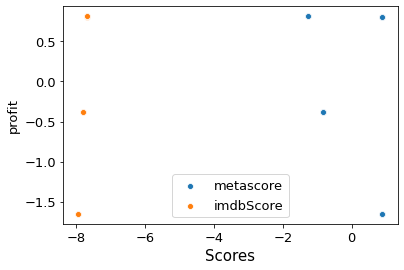

In [362]:
#DO NOT RUN
#VISUALIZATION: scatter plot, score vs profit (See procedure(D) 1)
fig, ax = plt.subplots()

sns.scatterplot(x = 'imdbScore', y = 'profit', data= singleGenre_df, ax=ax)
sns.scatterplot(x = 'metascore', y = 'profit', data= singleGenre_df, ax=ax)
ax.legend(labels = ['metascore', 'imdbScore'])
ax.set_xlabel("Scores", fontsize=15)

#save image
#plt.savefig('score_profit.png', bbox_inches = 'tight')

## ANSWER 3: Not exactly

In [ ]:
'''
Answer:
there is not as much evidence to provide that better scores implies better profit
ex: that we've seen Crime PG gives good profit but poor votes
'''

## MYSQL 

In [ ]:
'''
We did not make use of databases but:
If one wants to use a database to store the data scraped off the web via mysql:

note: one can store to a database especially if the data being scraped is very large, it is more efficient
to store to a database and call from the database 
'''

In [ ]:
#IMPORT mysql.connector and connect
import mysql.connector

mydb = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    passwd = <your_password>,
    database = 'moviedb'
    autocommit = True
)

mycursor = mydb.cursor()
mycursor.execute('CREATE DATABASE moviedb')

In [ ]:
#Create table: movieInfo 
mycursor.execute("""CREATE TABLE movieInfo (ids VARCHAR(255), 
                 title VARCHAR(255), genres VARCHAR(255), directors VARCHAR(255), year INTEGER(10))""")

In [ ]:
#add data to table: ids, title, genres, directors, years
def insertToMovieInfo(data_list):
    '''
    Parameters: data_list:<list> list of tuples to append to table
    Returns: appends to table
    '''
    for item in data_list:
        
        #INSERT INTO tablename, (columns) VALUES (%s)
        insert = "INSERT INTO movieInfo (ids, title, genres, directors, year) VALUES (%s, %s, %s, %s, %s)"

        mycursor.execute(insert, item)
        #mydb.commit()

In [ ]:
#(*) cell 1: the list of movies, top100_10yrs 
#we take tuple with ids, title, genres, directors, year 
boxOffice = [x[5] for x in top100_10yrs]
listToDf = [(x[0],x[1],x[2],x[3], x[4]) for x in top100_10yrs]

insertToMovieInfo(listToDf)  

In [ ]:
#how to retrieve
mycursor.execute("SELECT * FROM movieInfo")
myresult = mycursor.fetchall()

for x in myresult:
      print(x)

In [ ]:
#create separate table for boxoffice 
mycursor.execute("""CREATE TABLE movieBoxoffice (ids, VARCHAR(255), budget VARCHAR(255), 
                 opening_gross VARCHAR(255), USAgross VARCHAR(255), total_gross VARCHAR(255))""")
                 

In [ ]:
#turn boxOffice into tuple
boxOffice_tuple = []
for item in boxOffice:
        ids = item[0]
        box_office = item[1]
        data = (ids, box_office.get('budget'), box_office.get('openingWeekendUSA'), 
            box_office.get('grossUSA'), box_office.get('cumulativeWorldwideGross'))
        boxOffice_tuple.append(data)

In [ ]:
#insert function
def insertToMovieBoxOffice(data_list):
    '''
    Parameters: data_list:<list> list of tuples to append to table
    Returns: appends to table
    '''
    for item in data_list:
        insert = "INSERT INTO movieInfo (ids, title, genres, directors, year) VALUES (%s, %s, %s, %s, %s)"
    mycursor.execute(insert, item)

In [ ]:
#insert
insertToMovieBoxOffice(boxOffice_tuple)

In [ ]:
#Create table for scores
mycursor.execute("""CREATE TABLE movieScores (ids, VARCHAR(255), metascore VARCHAR(255), 
                 metacritic VARCHAR(255), mrating VARCHAR(255), imdbVotes VARCHAR(255), imdbScore VARCHAR(255)""")

In [ ]:
#insert function 
def insertToMovieScore(data_list):
    '''
    Parameters: data_list:<list> list of tuples to append to table
    Returns: appends to table
    '''
    for item in data_list:
        insert = """INSERT INTO movieScores (ids, metascore, metacritic, mrating, imdbVotes, imdbScore) 
        VALUES (%s, %s, %s, %s, %s)"""
        mycursor.execute(insert, item)
#insert         
insertToMovieScore(top100_10yrs2)

In [ ]:
#Create table for votes
mycursor.execute("""CREATE TABLE movieVotes (ids VARCHAR(255), title VARCHAR(255), one VARCHAR(255), 
                 two VARCHAR(255), three VARCHAR(255), four VARCHAR(255), five VARCHAR(255), six VARCHAR(255),
                 seven VARCHAR(255), eight VARCHAR(255), nine(255), ten(255)
                 """)

In [ ]:
#(*) cell three 
def insertToMovieVotes(data_list):
    '''
    Parameters: data_list:<list> list of tuples to append to table
    Returns: appends to table
    '''
    for item in data_list:
        insert = """INSERT INTO movieVotes (ids, title, one, two, three, four, five, six, seven,
        eight, nine, ten) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
        mycursor.execute(insert, item)

In [ ]:
#How to Merge:
#note: one could have made a "mega" table with ALL information which is better, so no joining is necessary 
mycursor.execute("""SELECT ids FROM movieInfo LEFT JOIN movieBoxOffice ON ids""")


In [ ]:
#Creating dataframe 
#When one has a large table it is a nice way to select subtables from a large table
mycursor.execute("SELECT ids,title,genres FROM movieInfo")
myresult = mycursor.fetchall()
dataframe = []

for x in myresult:
    dataframe.append(x)
df = pd.DataFrame(dataframe)

In [ ]:
#dont forget to close when you're done
mydb.close()